In [1]:
import numpy as np
import os 

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

### Importing MNIST Dataset with SK fetch_openml  

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True) # That dataset is an icon of classification tasks!
mnist.target = mnist.target.astype(np.int8) # Target is initially type object 

# sort_by_target(mnist)
X, y = mnist["data"], mnist["target"]
# Mnist comes already ordered with train / test
## First 60.000 instances are training!
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

In [3]:
some_digit = X[36000]

# Let's shuffle it just to guarantee that cross validation folds will be similar
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Playing with a Binary Classifier
Let's simplify the problem training a binary classifier that can predict if an image is a five!

In [4]:
print('Count total: ', len(y_train == 5))
print('Count fives: ', sum(y_train == 5))
print('Proportion fives: ', sum(y_train == 5) / len(y_train == 5))

y_train_5 = y_train == 5
y_test_5 = y_test == 5

Count total:  60000
Count fives:  5421
Proportion fives:  0.09035


In [5]:
# Let's Play with a simple SGDClassifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [6]:
# How is it going to perform with cross_val_score ?
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96355, 0.9447 , 0.9574 ])

In [7]:
# Let's build a base donkey estimator, that always say it's not 5!
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros(len(X), dtype=bool)
    
never_5_class = Never5Classifier()
never_5_class.fit(X_train, y_train_5)
cross_val_score(never_5_class, X_train, y_train_5, cv=3, scoring='accuracy')
# ... So accuracy is a really trash metric in this case =/

array([0.9071 , 0.91085, 0.911  ])

# Confusion Matrix, Recall And Precision!
Confusion matrix is a nice way to see how our model is classifying our results!

** SKLearn confusion matrix output:

Each row represents an actual class
Each colum represents a predicted class

<hr>
<ul style="list-style-type: none">
    <li style="font-size: 11px; color:orange"><b style="margin-right:40px;">Predicted Negatives</b><b>Predicted Positives</b></li>
   <li>| <b style="color: lightgreen;">true negative</b>   | <b style="color: red">false positive</b> | <b style="font-size: 11px; color:orange">-> Actual negatives</b></li>
    <li>| <b style="color: red">false negative</b> | <b style="color: lightgreen">true positive</b> | <b style="font-size: 11px; color:orange">-> Actual positives</b></li>
</ul>
<hr>

Precison = (true positive) / (true positive + false positive)
<hr>
Recall = (true positive) / (true positive + false positive)
<hr>

In [8]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [9]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)
# Hmmm is doesnt look not so good now 

array([[53317,  1262],
       [ 1425,  3996]])

In [10]:
from sklearn.metrics import precision_score, recall_score

print('Precision: ', precision_score(y_train_5, y_train_pred))
print('Recall: ', recall_score(y_train_5, y_train_pred))

Precision:  0.7599847850893876
Recall:  0.7371333702268954


In [11]:
# Manual Calc
precision = 4703 / (4703 + 2241)
print('Precision: ', precision)

recall = 4703 / (4703 + 718)
print('Recall: ', recall)

Precision:  0.6772753456221198
Recall:  0.8675521121564287


# F1-SCORE
<hr>
F1 score is the <b>harmonic mean</b> between recall and precision.
<hr>

It gives much more weight to low values,

so a f1 score will only be high if both precision and recall are high :)

In [12]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)
# f1_score is not bad

0.7483846802135032

# The Precision / Recall Tradeoff
A classifier computes a score based on a decision function.
If that score is greater than a treshold, it assigns he instance to the positive class, or else it assign it to the negative class.

Changing the value of the treshold, we can change the precision / recall results.


Raising the treshold increases precision and reduces recall.
Conversely, lowering treshold increases recall and reduces precision

In [13]:
y_scores = sgd_clf.decision_function(X_train)

In [14]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

threshold = 200000
y_some_digit_pred = (y_scores > threshold)

In [15]:
# Let's use cross_val_predict to get the scores (This time with method="decision_function")
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [16]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

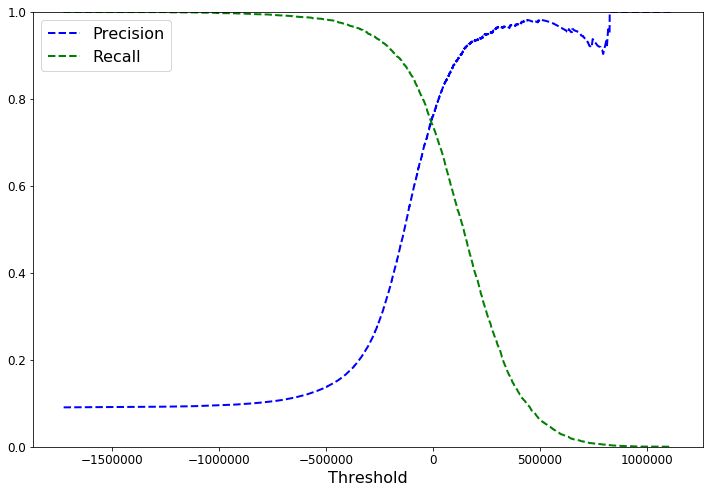

In [17]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(12, 8))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

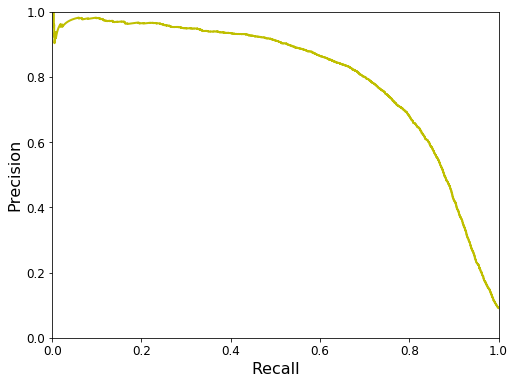

In [18]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "y-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

## Choosing The Treshold

Looking to the Precision X Recall curve, I want a treshold before that precision high drop!
0.9 precision would be ok!

Now i should find the treshold with the data of the first plot!

In [19]:
for p, t in zip(precisions, thresholds):
    if p >= 0.9:
        print('First 0.9 precison found!')
        print('Precision: ', p)
        print('Threshold: ', t)
        break

First 0.9 precison found!
Precision:  0.900094547746612
Threshold:  128764.97222338007


# Good!
I found the threshold for 90% precision is around 62000 
now let's calculate precision, recall and f1-score for this threshold

In [20]:
y_train_pred_90 = y_scores >= 62000

precision_score(y_train_5, y_train_pred_90)
recall_score(y_train_5, y_train_pred_90)
f1_score(y_train_5, y_train_pred_90)

0.7291950172720612

# The ROC Curve

The Receiver Operating Characteristic (ROC) curve is another common tool used with binary classifiers

Instead of plotting the precision versus recall, the ROC curve plots the TPR (true positive rate or Recall) vs the FPR (false positive rate).
The FPR is the ratio of the negative instances that are incorrectly classified as positive.


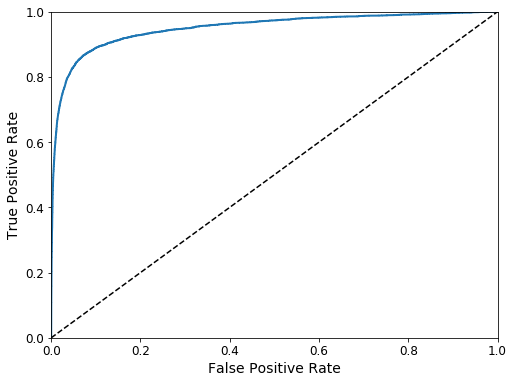

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)

# Nice, let's do the same with a Random Forest Classifier!
Then we can use a ROC Curve to Compare both!

In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)

# Random Forests don't have decision_functions but we can get the predict_proba

In [23]:
y_probas_predict = cross_val_predict(rf_clf, X_train, y_train_5, cv=3, method="predict_proba")

# THe output of predict_proba returns an array of two probs for each instance
## The first is the prob that the instance is negative
## The second is the prob that the instance is positive
## We are using the second for the score!
y_probas_forest = y_probas_predict[:, 1]

/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [24]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_probas_forest)

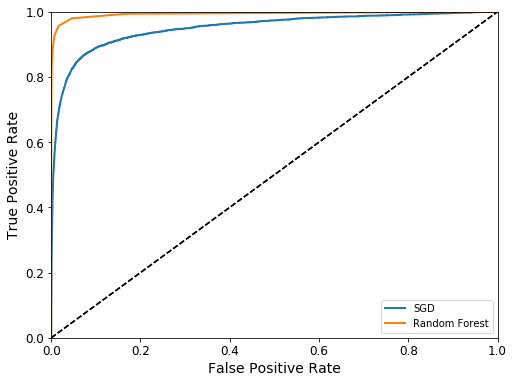

In [25]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr, 'SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')

plt.legend(loc="lower right")
plt.show()

## Nice, Random Forest is closer to the left upper corner, and has a better Area Under The Curve!

In [26]:
from sklearn.metrics import roc_auc_score

print('AUC SGD: ', roc_auc_score(y_train_5, y_scores))
print('AUC Random Forest: ', roc_auc_score(y_train_5, y_probas_forest))

AUC SGD:  0.95005279955496
AUC Random Forest:  0.9930843565764026


<h1> MultiClass Classification</h1>
<hr>

That was a nice tour into binary classification, now let's do the <b>Multiclass Classification!</b>

Some models like Random Forest and Naive Bayes can directly do a multiclass classfication. <br>
Others like SVM are only binary classifiers.

We have two main strategies to do multiclass classification for binary classifiers:
<ol>
    <li> OvA (One vs All)</li>
    <li> OvO (One vs One) </li>     
</ol>

In the case of One vs all we will train 10 classifiers, one for each output.

In the case of One vs One, we will train each pair of classifiers, so in this case we will train (10 * (10 - 1)) / 2 = 45 classifiers

In [27]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [28]:
sgd_clf.decision_function([some_digit])
# Under the hood, sckit learn uses OvA, making 10 classifiers and than using the highest score.b

array([[-771323.15100468, -428120.25394187, -687004.77584301,
        -211074.09964393,  -97299.14358216, -276941.34601668,
        -617360.77485778, -173076.86492544, -452914.93207909,
        -273376.45386557]])

# Forcing OvO or OvA

By default, sklearn will use OvA for most of the binary classifiers, but we can force it do use OvO or OvA using the classes OneVsOneClassifier or OneVsRestClassifier

In [29]:
from sklearn.multiclass import OneVsOneClassifier

ovo_sgd_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_sgd_clf.fit(X_train, y_train)

/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol 

/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol 

/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol 

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [30]:
len(ovo_sgd_clf.estimators_) # Wow, there are 45 classifiers!

45

In [31]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
print('SGD OvA Accuracy: ', cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy"))
print('SGD OvO Accuracy: ', cross_val_score(ovo_sgd_clf, X_train, y_train, cv=3, scoring="accuracy"))
print('RF Accuracy: ', cross_val_score(rf_clf, X_train, y_train, cv=3, scoring="accuracy"))

/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol 

SGD OvA Accuracy:  [0.82978404 0.88529426 0.87323098]


/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol 

/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol 

/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol 

/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol 

/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol 

/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol 

/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol 

SGD OvO Accuracy:  [0.90646871 0.91349567 0.91673751]
RF Accuracy:  [0.94336133 0.94084704 0.94104116]


In [33]:
# Let's get better scaling the inputs!

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol 

array([0.90886823, 0.90779539, 0.9106866 ])

# Error Analysis
let's see the confusion matrix

In [34]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx # wow that's a lot of numbers!

/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/nakamuta/Documents/Personal/HandsOnMl/venv/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol 

array([[5733,    2,   21,   10,   11,   50,   46,    8,   39,    3],
       [   1, 6462,   48,   24,    5,   40,    9,    9,  133,   11],
       [  56,   42, 5303,  107,   84,   23,  108,   54,  166,   15],
       [  45,   41,  140, 5329,    2,  254,   33,   55,  136,   96],
       [  18,   29,   39,   10, 5334,    9,   56,   35,   85,  227],
       [  73,   45,   35,  178,   75, 4607,  116,   32,  171,   89],
       [  32,   23,   54,    2,   38,   89, 5633,    5,   42,    0],
       [  26,   21,   70,   28,   47,    9,    5, 5834,   17,  208],
       [  51,  147,   68,  155,   12,  169,   54,   26, 5031,  138],
       [  39,   37,   29,   84,  144,   34,    2,  219,   80, 5281]])

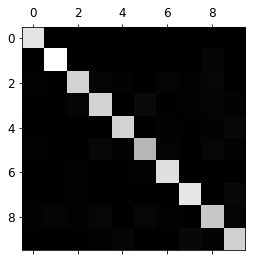

<Figure size 576x432 with 0 Axes>

In [35]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.figure(figsize=(8,6))
plt.show()

It's good to see that the main diagonal contains most of the numbers, some cols are brither than others, meaning that there are some labels that are being more missclassified than others.

#### Let's dive deeper into the Errors!

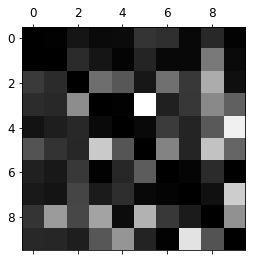

In [36]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
norm_conf_mx

np.fill_diagonal(norm_conf_mx, 0) # Since we are focusing on errors, let's zero the diagonals
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)

## Exploring the confusing matrix can give us insights about how to improve our model

For example, there is a lot of confusion about 3/5. So we could get more data on this labels, engineer new features that would help the classifier (ex: number of loops -> 8 has two, 5 has 1), and even preprocess the images to make some patterns stand out more such as closed loops!

for now, let's explore the 3 and 5 confusion

In [37]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

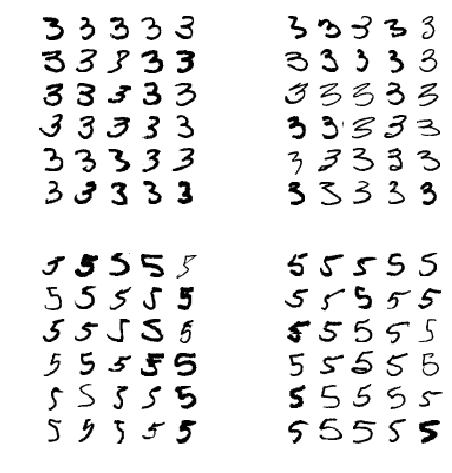

In [38]:
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:30], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:30], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:30], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:30], images_per_row=5)
plt.show()

# Multilabel Classification
In some cases we want our models to output multiple classes for each instance. This is called multilabel classification!

In [39]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf.fit(X_train_scaled, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [40]:
def show_digit(digit):
    digit_reshaped = digit.reshape(28,28)
    plt.imshow(digit_reshaped, cmap=mpl.cm.binary)
    plt.show()

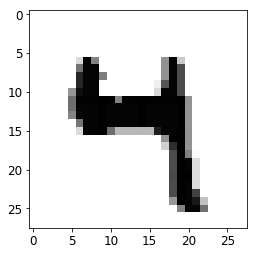

In [41]:
show_digit(X_train[3000])

In [42]:
knn_clf.predict([X_train[3000]]) # It is correct!

array([[ True,  True]])

In [ ]:
# Let's Calculate the f1_score!
## In this case we assume that our labels are equally important, so the f1-score is going to be calculated for each label and then the final score is the average between both!
y_train_pred_kn = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [ ]:
f1_score(y_multilabel, y_train_pred_kn, average="macro")